In [1]:
%pip install plotly
%pip install imageio
%pip install pandas
%pip install ipympl
%pip install scikit-image
%pip install plotly

You should consider upgrading via the '/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the '/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the '/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf 
import numpy as np  
import imageio
import json
import skimage
import plotly.express as px
import plotly.graph_objects as go
import cv2
import matplotlib.pyplot as plt
# from psbody.mesh import Mesh
import scipy
%matplotlib widget
from mano import Mano
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tqdm.notebook as tq

from utils import read_mano, scatter3d, update_fig_range, plot_2d_pts_on_img

In [1]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

NameError: name 'tf' is not defined

# Read Data

In [4]:
tf.random.set_seed(124)
np.random.seed(124)
out_img_size = 224
n_verts_to_predict = 778
pad = 30
CROP_OFFSET_RANGE = [-5, 5]
ROTATION_RANGE = [-180, 180]
imagenet_mean=np.array([0.485, 0.456, 0.406])
imagenet_std=np.array([0.229, 0.224, 0.225])

In [5]:
def visualize_in_orig_image(image, annotations):
    """
    Visualize hand annotations and image on uncropped image
    """
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    vertices = np.array(annotations)
    plt.plot(vertices[:, 0], vertices[:, 1], 'o', color='green', markersize=1)
    plt.show()
    
def translation_mat(tx=0, ty=0, tz=0):
    """
    4x4 translational matrix
    """
    mat = np.eye(4)
    mat[0:3, 3] = np.array([tx, ty, tz]).T
    return mat

def flip_hand(adjusted_vertices, cropped_image, is_left):
    """
    Flip left hand to mirrored right hand coordinates
    """
    flip_mat = np.eye(4)
    if is_left:
        cropped_image = cropped_image[:, -1::-1, :]
        flip_mat = translation_mat(cropped_image.shape[1])
        flip_mat[0, 0] = -1
        adjusted_vertices = np.hstack((adjusted_vertices, np.ones((778, 1)))) @ flip_mat.T
    return cropped_image, adjusted_vertices[..., :3], flip_mat

def map_img_to_path(img_dct, images):
    """
    Preprocessing function to create a image id to details mapping
    """
    for i in images:
        if i['id'] not in img_dct:
            img_dct[i['id']] = {}
        img_dct[i['id']]['path'] = i['name']
        img_dct[i['id']]['width'] = i['width']
        img_dct[i['id']]['height'] = i['height']
        
def map_img_to_ann(img_dct, annotations):
    """
    Preprocessing function to create a image id to list of annotations
    """
    for idx, ann in enumerate(annotations):
        if ann['image_id'] not in img_dct:
            img_dct[ann['image_id']] = {}
        if 'ann' not in img_dct[ann['image_id']]:
            img_dct[ann['image_id']]['ann'] = []
        img_dct[ann['image_id']]['ann'].append(idx)

def crop(I, V, augment):
    min_coords, max_coords = np.amin(V, axis=0), np.amax(V, axis=0)
    min_uv, max_uv = min_coords[:2].astype(np.int), max_coords[:2].astype(np.int)
    if augment:
        min_uv -= np.random.randint(0, pad, (2))
        max_uv += np.random.randint(0, pad, (2))
    I_shape = np.shape(I)
    I_crop = I.copy()[max(min_uv[1], 0): min(max_uv[1], I_shape[0]), max(min_uv[0], 0): min(max_uv[0], I_shape[1])]
    mat_crop = np.identity(4, dtype=np.float32)
    mat_crop[0, 3] = -min_uv[0]
    mat_crop[1, 3] = -min_uv[1]
    return I_crop, mat_crop

def get2Drot(angle, scale, cx, cy):
    alpha = scale*np.cos(angle)
    beta = scale*np.sin(angle)
    return np.array([[alpha, beta, (1-alpha)*cx-beta*cy],
                     [-beta, alpha, beta*cx+(1-alpha)*cy]])

## Input

In [6]:
# ./tmp2/training/rgb/
from PIL import Image
img_path = "../storage/training/rgb/00000000.jpg"
I = imageio.imread(img_path)
Ic = I.copy()
plt.imshow(I)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
mask_path = "../storage/training/mask/00000000.jpg"
I_m = imageio.imread(mask_path)
plt.imshow(I_m)

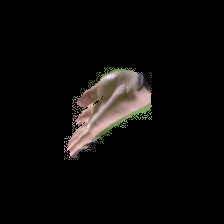

In [11]:
mask_path = "../storage/training/mask/00000000.jpg"
I_m = imageio.imread(mask_path)
plt.imshow(I_m)
Image.fromarray(np.multiply(np.array(I_m)!=0, np.array(I), dtype=np.uint8))

In [12]:
len(I[0])

224

## Annotation
x, y coordinates are in image frame.
What does the z coordinate denote?

In [18]:
with open('../storage/sample_freihand_1.json') as f:
    training = json.load(f)

# with open('../storage/training_K.json') as f:
#     training_K = json.load(f)    

# with open('../storage/training_mano.json') as f:
#     training_mano = json.load(f)

# with open('./tmp2/sample.json') as f:
#     evalt = json.load(f)

K, mano, xyz = training['K'], training['mano'], training['xyz']
# K, mano, xyz = evalt['ls'][11]['K'], evalt['ls'][11]['mano'], training['xyz']

In [19]:
from util.fh_utils import *
from util.model import *

mano = np.array(mano)
K = np.array(K)

poses, shapes, uv_root, scale = split_theta(mano)
focal, pp = get_focal_pp(K)
xyz_root = recover_root(uv_root, scale, focal, pp)

# set up the hand model and feed hand parameters
renderer = HandModel(use_mean_pca=False, use_mean_pose=True)
renderer.pose_by_root(xyz_root[0], poses[0], shapes[0])
msk_rendered, V1 = renderer.render(K, img_shape=I.shape[:2])

proj = projectPoints(V1, K)
print(proj.shape)        
s_x = np.std(proj[:, 0]) / np.std(V1[:, 0])
z_cam = s_x *(V1[:, 2]).reshape(-1, 1)
V_gt = np.concatenate((proj[:, :2], z_cam), axis=1)

proj_mat = K
proj_mat = np.hstack([proj_mat, np.zeros((3, 1))])
proj_mat = np.vstack([proj_mat, [0, 0, 0, 1]])
proj_mat[2, 2] = s_x
P = proj_mat
    
visualize_in_orig_image(I, V_gt)

(778, 2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
print(V_gt[:3, :])

[[107.74166095  94.44565978 369.80796445]
 [110.09056282  91.36077013 362.89060693]
 [106.0439555   90.59055553 367.41822648]]


In [21]:
V1

[[-0.00688691 -0.02840404  0.6289612 ]
 [-0.00303032 -0.03277091  0.61719631]
 [-0.00957032 -0.03441798  0.62489679]
 ...
 [-0.02643143  0.00984758  0.6085137 ]
 [-0.03090127  0.01534423  0.61700929]
 [-0.01368385 -0.00553865  0.60155092]]

In [22]:
# with open('../storage/sample_friehand/sample_friehand.json') as f:
#     annotation_json = json.load(f)

# V_gt = np.array(annotation_json['anns']).astype(np.float32)

# visualize_in_orig_image(I, V_gt)

In [23]:
# fig = plot_2d_pts_on_img(I, V2)
# fig.show()

# Process data

## Crop

In [24]:
# min_coords, max_coords = np.amin(V_gt, axis=0), np.amax(V_gt, axis=0)
# min_uv, max_uv = min_coords[:2].astype(np.int), max_coords[:2].astype(np.int)
# # I_crop = I[min_uv[1]: max_uv[1], min_uv[0]: max_uv[0]]  # u: cols, v: rows
# I_crop = Ic

# mat_crop = np.identity(4, dtype=np.float32)
# mat_crop[0, 3] = -min_uv[0]
# mat_crop[1, 3] = -min_uv[1]

I_crop, mat_crop = crop(I, V_gt, 1)
V_crop = V_gt @ mat_crop[:3, :3].T + mat_crop[:3, 3]

visualize_in_orig_image(I_crop, V_crop)
print(np.shape(I_crop))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(107, 100, 3)


## Resize

In [25]:


cropped_height, cropped_width, _ = I_crop.shape
resize_scale = min(out_img_size/cropped_width, out_img_size/cropped_height)
resized_width, resized_height = (int(cropped_width*resize_scale), int(cropped_height*resize_scale))
I_resize = cv2.resize(I_crop, (resized_width, resized_height), interpolation=cv2.INTER_LINEAR)

mat_resize = np.identity(4, dtype=np.float32)
mat_resize[0, 0] = resize_scale
mat_resize[1, 1] = resize_scale
V_resize = V_crop @ mat_resize[:3, :3].T + mat_resize[:3, 3]

visualize_in_orig_image(I_resize, V_resize)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Pad

In [26]:
I_pad = np.zeros([out_img_size, out_img_size, 3], dtype=np.uint8)
u_pad_start, v_pad_start = int((out_img_size - resized_width) / 2), int((out_img_size - resized_height) / 2)
u_pad_end, v_pad_end = u_pad_start + resized_width, v_pad_start + resized_height
I_pad[v_pad_start : v_pad_end, u_pad_start : u_pad_end] = I_resize

mat_pad = np.eye(4, dtype=np.float32)
mat_pad[0, 3] = u_pad_start
mat_pad[1, 3] = v_pad_start
V_pad = V_resize @ mat_pad[:3, :3].T + mat_pad[:3, 3]

visualize_in_orig_image(I_pad, V_pad)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
np.sum(np.sum(I_pad))-np.sum(np.sum(I_resize))

0

In [28]:
sum(np.array([[1, 2, 3], [2, 3, 4]]))

array([3, 5, 7])

## Normalize

In [29]:
I_normalize = I_pad.copy().astype(np.float32)
I_normalize /= 255

shift_z = np.min(V_pad[:, 2])
scale_z = np.max(V_pad[:, 2])-np.min(V_pad[:, 2])

# V_normalize = V_pad.copy()
# V_normalize[:, :2] = V_normalize[:, :2] / ( out_img_size/2 ) - 1 
# V_normalize[:, 2] = (V_normalize[:, 2] - shift_z) / (scale_z/2 ) - 1 

mat_normalize = np.eye(4, dtype=np.float32)
mat_normalize[0, 0] = 2/out_img_size
mat_normalize[1, 1] = 2/out_img_size
mat_normalize[2, 2] = 2/scale_z

mat_normalize[0:3, 3] = [-1, -1, -(shift_z*2)/scale_z-1]
V_normalize = np.ones((778, 4))
V_normalize[:, :3] = V_pad.copy()
V_normalize = (mat_normalize @ V_normalize.T).T[:, :3]

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(I_normalize)

ax2 = fig.add_subplot(122)
ax2.scatter(V_normalize[:, 0], V_normalize[:, 1])
ax2.set_xlim(-1, 1)
ax2.set_ylim(1, -1)
ax2.set_aspect("equal")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
print(np.sum(I_normalize), np.sum(V_normalize))

59407.71 -64.0057496730918


In [31]:
# Image.fromarray(I_normalize[:,:,0])
a = Image.fromarray((I_pad).astype('uint8'), 'RGB')
np.mean(I_pad) - np.mean(np.asarray(a))
a
g = skimage.transform.AffineTransform(rotation=random_angle_in_degrees, scale=random_scale)
cv2.getRotationMatrix2D((out_img_size/2, out_img_size/2), random_angle_in_degrees, random_scale)
# g = skimage.transform.AffineTransform(np.vstack([cv_mat_rot_scale, [0, 0, 1]]))

# xx = skimage.transform.warp(I_pad.astype(np.float32), ProjectiveTransform(matrix=np.vstack([cv_mat_rot_scale, [0, 0, 1]])))
# Image.fromarray((xx).astype('uint8'), 'RGB')
print( g.params, cv2.getRotationMatrix2D((out_img_size/2, out_img_size/2), random_angle_in_degrees, random_scale), random_scale * np.cos(random_angle_in_degrees))
get2Drot(random_angle_in_degrees, random_scale, 112, 112)

NameError: name 'random_angle_in_degrees' is not defined

In [42]:
# print(np.random.rand(), np.random.rand())
random_angle_in_degrees = np.random.rand() * (ROTATION_RANGE[1]-ROTATION_RANGE[0]) - ROTATION_RANGE[0]
random_scale = np.random.rand()*0.1 + 1.0
cv_mat_rot_scale_c = get2Drot(random_angle_in_degrees, random_scale, out_img_size/2, out_img_size/2)
cv_mat_rot_scale_ac = get2Drot(-random_angle_in_degrees, random_scale, out_img_size/2, out_img_size/2)
# cv2.getRotationMatrix2D((out_img_size/2, out_img_size/2), random_angle_in_degrees, random_scale)
# cv_mat_rot_scale_ac = cv2.getRotationMatrix2D((out_img_size/2, out_img_size/2), -random_angle_in_degrees, random_scale)
# cv_mat_rot_scale = skimage.transform.AffineTransform(rotation=random_angle_in_degrees, scale=random_scale)

# rotated_and_scaled_image = cv2.warpAffine(I_normalize, cv_mat_rot_scale, (out_img_size, out_img_size), borderValue=0, flags=cv2.INTER_NEAREST)
# rotated_and_scaled_image = np.array(Image.fromarray((I_pad).astype('uint8'), 'RGB').transform((out_img_size, out_img_size), Image.AFFINE, tuple(list(np.ndarray.flatten(cv_mat_rot_scale))), resample=Image.BICUBIC), dtype=np.uint8)
aff_tr = skimage.transform.AffineTransform(np.vstack([cv_mat_rot_scale_c, [0, 0, 1]]))
rotated_and_scaled_image = skimage.transform.warp(I_normalize, aff_tr)

# I_normalize = rotated_and_scaled_image.copy().astype(np.float32)
# rotated_and_scaled_image = rotated_and_scaled_image.copy().astype(np.float32) / 255
rotated_and_scaled_image = rotated_and_scaled_image * random_scale
# print(cv_mat_rot_scale)
mat_rot_scale = np.eye(4, dtype=np.float32)
# mat_rot_scale[:2, :2] = cv_mat_rot_scale[:2, :2]
mat_rot_scale[:2, :2] = cv_mat_rot_scale_ac[:2, :2]
tmp = np.zeros((778, 4))
tmp[:,:3] = V_normalize
tmp[:, 3] = 1
rotated_scaled_vertices = tmp @ mat_rot_scale.T
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(rotated_and_scaled_image)

ax2 = fig.add_subplot(122)
ax2.scatter(rotated_scaled_vertices[:, 0], rotated_scaled_vertices[:, 1])
ax2.set_xlim(-1, 1)
ax2.set_ylim(1, -1)
ax2.set_aspect("equal")

# ax3 = fig.add_subplot(133)
# ax3.scatter(V_normalize[:, 0], V_normalize[:, 1])
# ax3.set_xlim(-1, 1)
# ax3.set_ylim(1, -1)
# ax3.set_aspect("equal")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
print(tuple(list(np.ndarray.flatten(cv_mat_rot_scale))), cv_mat_rot_scale)

In [ ]:
print(np.shape(rotated_scaled_vertices))

In [ ]:
intensity_normalized_image = (rotated_and_scaled_image - imagenet_mean)/imagenet_std
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(intensity_normalized_image)

In [ ]:
print(np.min(V_normalize), np.max(V_normalize))
shift_z

In [ ]:
V_normalize

In [ ]:
V_gt

# Unprocess

In [43]:
# unnormalize
V_un = rotated_scaled_vertices[:, :3].copy()
# V_unnormalize[:, :2] = (V_unnormalize[:, :2] + 1) * (out_img_size/2)
# V_unnormalize[:, 2] = (V_unnormalize[:, 2] + 1) * (scale_z/2) + shift_z

# unprocess
mat_process = mat_rot_scale @ mat_normalize @ mat_pad @ mat_resize @ mat_crop
mat_unprocess_3x3 = np.linalg.inv(mat_process[:3, :3])
mat_unprocess_t = mat_unprocess_3x3 @ (-mat_process[:3, 3])
V_unprocess = V_un @ mat_unprocess_3x3.T + mat_unprocess_t

visualize_in_orig_image(I, V_unprocess)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [236]:
mat_process

array([[-1.9256692e-02, -1.3838597e-05,  0.0000000e+00,  2.1613014e+00],
       [ 1.3838597e-05, -1.9256692e-02,  0.0000000e+00,  2.1455691e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.9039635e-02, -7.2431879e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [237]:
V_orig = V_unprocess.copy()
# V_orig[..., 2] = V_orig[..., 2] / proj_mat[2, 2]
# V_orig[..., 0] = (V_orig[..., 0] - proj_mat[0, 2]) / proj_mat[0, 0] * V_orig[..., 2]
# V_orig[..., 1] = (V_orig[..., 1] - proj_mat[1, 2]) / proj_mat[1, 1] * V_orig[..., 2]

In [238]:
print(V1[:3, :], V_orig[:3, :])

[[-0.00688691 -0.02840404  0.6289612 ]
 [-0.00303032 -0.03277091  0.61719631]
 [-0.00957032 -0.03441798  0.62489679]] [[107.74165557  94.44565446 369.80795032]
 [110.09055743  91.36076482 362.89059302]
 [106.04395014  90.59055022 367.41821242]]


In [239]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(I)

ax2 = fig.add_subplot(122)
ax2.scatter(V_orig[:, 0], V_orig[:, 1])
ax2.set_aspect("equal")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [240]:
print(np.min(V_unprocess[:, 2]), np.max(V_unprocess[:, 2]))

327.9047927634101 432.94881817864257


In [241]:
n_verts_to_predict = 778

In [197]:
ref_i = rotated_and_scaled_image
ref_v = rotated_scaled_vertices
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(ref_i)

ax2 = fig.add_subplot(122)
ax2.scatter(ref_v[:, 0], ref_v[:, 1])
ax2.set_xlim(-1, 1)
ax2.set_ylim(1, -1)
ax2.set_aspect("equal")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [198]:
# annotation = tf.constant([[[1, 1, 1], [2, 2, 2,]], [[1, 1, 1], [2, 2, 2,]]])
# annotation = tf.stack([annotation, tf.expand_dims(tf.ones(tf.shape(annotation)[:-1]), axis=-1)], axis=-1)
# annotation

# TF Dataset

In [199]:
ds_train1 = tf.data.Dataset.from_tensors(({"I": I_normalize, "proj_mat" : P, "affine_mat" : mat_process}, {"V": V_normalize[:n_verts_to_predict, :3], "annotations_xyz" : V1}))
ds_train1 = ds_train1.batch(1)

ds_val1 = tf.data.Dataset.from_tensors(({"I": I_normalize, "proj_mat" : P, "affine_mat" : mat_process}, {"V": V_normalize[:n_verts_to_predict, :3], "annotations_xyz" : V1}))
ds_val1 = ds_val1.batch(1)

print(ds_train1)

<BatchDataset shapes: ({I: (None, 224, 224, 3), proj_mat: (None, 4, 4), affine_mat: (None, 4, 4)}, {V: (None, 778, 3), annotations_xyz: (None, 778, 3)}), types: ({I: tf.float32, proj_mat: tf.float64, affine_mat: tf.float32}, {V: tf.float64, annotations_xyz: tf.float64})>


In [196]:
np.asarray(V1)

array([[-0.00688691, -0.02840404,  0.6289612 ],
       [-0.00303032, -0.03277091,  0.61719631],
       [-0.00957032, -0.03441798,  0.62489679],
       ...,
       [-0.02643143,  0.00984758,  0.6085137 ],
       [-0.03090127,  0.01534423,  0.61700929],
       [-0.01368385, -0.00553865,  0.60155092]])

In [197]:
im, uvd, mp = freihand_projection(I, np.asarray(V1), K)
ni, nv, ma = process_data(im, uvd)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(ni)

ax2 = fig.add_subplot(122)
ax2.scatter(nv[:, 0], nv[:, 1])
# ax2.set_xlim(-1, 1)
# ax2.set_ylim(1, -1)
ax2.set_aspect("equal")

ds_train2 = tf.data.Dataset.from_tensors(({"I": ni, "proj_mat" : mp, "affine_mat" : ma}, {"V": nv, "annotations_xyz" : np.asarray(V1)}))
ds_train2 = ds_train2.batch(1)

ds_val2 = tf.data.Dataset.from_tensors(({"I": ni, "proj_mat" : mp, "affine_mat" : ma}, {"V": nv, "annotations_xyz" : np.asarray(V1)}))
ds_val2 = ds_val2.batch(1)

print(ds_train2)

ValueError: cannot reshape array of size 0 into shape (1,2)

In [18]:
annotation_json_100 = [{'mano': training['mano'], 'K': K}]


In [6]:
storage_dir = '../storage/'
with open(storage_dir+'correct_sample.json') as f:
    sample_youtube_data = json.load(f)


In [5]:
# sample_youtube_data

In [109]:
# with open('../storage/training_.json') as f:
#     full_annotation = json.load(f)

In [7]:
with open('../storage/training_K.json') as f:
    full_annotation_K = json.load(f)

In [8]:
with open('../storage/training_mano.json') as f:
    full_annotation_mano = json.load(f)

In [32]:
len(full_annotation_mano)

NameError: name 'full_annotation_mano' is not defined

In [9]:
annotation_json = []
for i in range(len(full_annotation_mano)):
    annotation_json.append({'mano': full_annotation_mano[i], 'K': full_annotation_K[i]})

In [37]:
len(annotation_json)

32560

In [10]:
annotation_json = []
for i in tq.tqdm(range(len(full_annotation_mano))):
    mano = np.array(full_annotation_mano[i])
    K = np.array(full_annotation_K[i])

    poses, shapes, uv_root, scale = split_theta(mano)
    focal, pp = get_focal_pp(K)
    xyz_root = recover_root(uv_root, scale, focal, pp)
    
    # set up the hand model and feed hand parameters
    renderer = HandModel(use_mean_pca=False, use_mean_pose=True)
    # print("Hellllllo")
    renderer.pose_by_root(xyz_root[0], poses[0], shapes[0])
    msk_rendered, V1 = renderer.render(K, img_shape=I.shape[:2])
    annotation_json.append({'V':V1, 'K':K})
with open('ann.json', 'w') as f:
    json.dump({'anns':annotation_json}, f)

NameError: name 'full_annotation_mano' is not defined

In [10]:
def process_data_wrapper(projection_func):
    #Load these in process_ds for parallelisation
    def f(image_path, annotation, *args):
        image = np.asarray(Image.open(image_path.numpy()))
        annotation = annotation.numpy()
        image, annotation_xyz, annotation_uvd, proj_mat = projection_func(image, annotation, *args)
        normalized_image, normalized_annotations, affine_mat = process_data(image, annotation_uvd)
    
        return normalized_image, annotation_xyz, normalized_annotations, affine_mat, proj_mat
    return f

def youtube_projection(image, annotation_id, image_width, image_height, hand_is_left):
    image_height = image_height.numpy()
    image_width = image_width.numpy()
    hand_is_left = hand_is_left.numpy()
    annotation = np.array(sample_youtube_data['annotations'][annotation_id]['vertices'])
    ## Resize
    image = np.array(image.resize((image_width, image_height)))
    ## Flip
    flipped_image, flipped_vertices, flip_mat = flip_hand(annotation, image, hand_is_left)
    ## Return proj mat
    return flipped_image, annotation, flipped_vertices, flip_mat

def freihand_projection(image, mano, projection_mat, image_mask_path):
    ## Apply projection mat
    # print(annotation_xyz[:3, :])
    mask = np.asarray(Image.open(image_mask_path.numpy()))
    image = np.multiply(np.array(mask)!=0, np.array(image), dtype=np.uint8)
    
    poses, shapes, uv_root, scale = split_theta(mano)
    focal, pp = get_focal_pp(projection_mat)
    xyz_root = recover_root(uv_root, scale, focal, pp)
    
    # set up the hand model and feed hand parameters
    renderer = HandModel(use_mean_pca=False, use_mean_pose=True)
    # print("Hellllllo")
    renderer.pose_by_root(xyz_root[0], poses[0], shapes[0])
    msk_rendered, annotation_xyz = renderer.render(projection_mat, img_shape=image.shape[:2])
    
    annotation_uv = projectPoints(annotation_xyz, projection_mat)
    projection_mat = np.hstack([projection_mat, np.zeros((3, 1))])
    projection_mat = np.vstack([projection_mat, [0, 0, 0, 1]])
    ## Scale z coord
    s_x = np.std(annotation_uv[:, 0]) / np.std(annotation_xyz[:, 0])
    z_cam = s_x * (annotation_xyz[:, 2]).reshape(-1, 1)
    projection_mat[2, 2] = s_x
    ## Add z scale to proj
    annotation_uvd = np.concatenate((annotation_uv[:, :2], z_cam), axis=1)
    ## Return modified proj mat
    # print(annotation_uvd[:3, :])
    return np.array(image), annotation_xyz, annotation_uvd, projection_mat

def unproject_youtube(annotation, affine_mat, proj_mat):
    mat_project = tf.matmul(affine_mat, proj_mat)
    mat_unproject = tf.linalg.inv(mat_project[:, :3, :3])
    inv_t = tf.matmul(-mat_project[:, :3, 3][..., tf.newaxis], mat_unproject, transpose_a=True, transpose_b=True)
    iv1 = tf.matmul(annotation, mat_unproject, transpose_b=True) + inv_t
    return iv1

# def unproject_freihand(_annotation, _affine_mat, _proj_mat):
#     def f(annotation, affine_mat, proj_mat):
#         mat_project = affine_mat
#         mat_unproject = np.linalg.inv(mat_project[:3, :3])
#         inv_t = mat_unproject @ -mat_project[:3, 3]
#         annotation = annotation @ mat_unproject.T + inv_t.T
#         print(annotation)
#         annotation[..., 2] = annotation[..., 2] / proj_mat[2, 2]
#         annotation[..., 0] = (annotation[..., 0] - proj_mat[0, 2]) / proj_mat[0, 0] * annotation[..., 2]
#         annotation[..., 1] = (annotation[..., 1] - proj_mat[1, 2]) / proj_mat[1, 1] * annotation[..., 2]
#         return annotation
#     _annotation = _annotation.numpy()
#     for idx, _ in enumerate(_annotation):
#         _annotation[idx] = f(_annotation[idx], _affine_mat[idx].numpy(), _proj_mat[idx].numpy())
#     # print(_annotation.shape)
#     return _annotation

def unproject_freihand(annotation, affine_mat, proj_mat):
#     tf.cast(annotation, tf.float64)
#     tf.cast(affine_mat, tf.float64)
#     tf.cast(proj_mat, tf.float64)
    mat_project = affine_mat
    mat_unproject = tf.linalg.inv(mat_project[:, :3, :3])
    inv_t = tf.matmul(-mat_project[:, :3, 3][..., tf.newaxis], mat_unproject, transpose_a=True, transpose_b=True)
    iv1 = tf.matmul(annotation, mat_unproject, transpose_b=True) + inv_t
#     print(iv1)
#     print(tf.matmul(tf.concat([annotation, tf.ones_like(annotation[..., 1:2])], axis=-1), tf.linalg.inv(affine_mat), transpose_b=True)[..., :3])
#     print(tf.reduce_sum(iv1 - tf.matmul(tf.concat([annotation, tf.ones_like(annotation[..., 1:2])], axis=-1), tf.linalg.inv(affine_mat), transpose_b=True)[..., :3]))
    iv1_d = iv1[..., 2] / proj_mat[..., 2, 2][..., tf.newaxis]
    iv1_u = (iv1[..., 0] - proj_mat[..., 0, 2][..., tf.newaxis]) / proj_mat[..., 0, 0][..., tf.newaxis] * iv1_d 
    iv1_v = (iv1[..., 1] - proj_mat[..., 1, 2][..., tf.newaxis]) / proj_mat[..., 1, 1][..., tf.newaxis] * iv1_d
    return tf.concat([iv1_u[..., tf.newaxis], iv1_v[..., tf.newaxis], iv1_d[..., tf.newaxis]], axis=-1)

def process_data(I, V_gt):
    I_crop, mat_crop = crop(I, V_gt, 1)
    V_crop = V_gt @ mat_crop[:3, :3].T + mat_crop[:3, 3]
    cropped_height, cropped_width, _ = I_crop.shape
    resize_scale = min(out_img_size/cropped_width, out_img_size/cropped_height)
    resized_width, resized_height = (int(cropped_width*resize_scale), int(cropped_height*resize_scale))
    I_resize = cv2.resize(I_crop, (resized_width, resized_height), interpolation=cv2.INTER_LINEAR)

    mat_resize = np.identity(4, dtype=np.float32)
    mat_resize[0, 0] = resize_scale
    mat_resize[1, 1] = resize_scale
    V_resize = V_crop @ mat_resize[:3, :3].T + mat_resize[:3, 3]
    
    I_pad = np.zeros([out_img_size, out_img_size, 3], dtype=np.float32)
    u_pad_start, v_pad_start = int((out_img_size - resized_width) / 2), int((out_img_size - resized_height) / 2)
    u_pad_end, v_pad_end = u_pad_start + resized_width, v_pad_start + resized_height
    I_pad[v_pad_start : v_pad_end, u_pad_start : u_pad_end] = I_resize

    mat_pad = np.eye(4, dtype=np.float32)
    mat_pad[0, 3] = u_pad_start
    mat_pad[1, 3] = v_pad_start
    V_pad = V_resize @ mat_pad[:3, :3].T + mat_pad[:3, 3]

    I_normalize = I_pad.copy()
    I_normalize /= 255

    shift_z = np.min(V_pad[:, 2])
    scale_z = np.max(V_pad[:, 2])-np.min(V_pad[:, 2])
    
    mat_normalize = np.eye(4, dtype=np.float32)
    mat_normalize[0, 0] = 2/out_img_size
    mat_normalize[1, 1] = 2/out_img_size
    mat_normalize[2, 2] = 2/scale_z

    mat_normalize[0:3, 3] = [-1, -1, -(shift_z*2)/scale_z-1]
    
    V_normalize = np.ones((778, 4))
    V_normalize[:, :3] = V_pad.copy()
    V_normalize = (mat_normalize @ V_normalize.T).T[:, :3]
    # Rotation
    random_angle_in_degrees = np.random.rand() * (ROTATION_RANGE[1]-ROTATION_RANGE[0]) - ROTATION_RANGE[0]
    random_scale = np.random.rand()*0.1 + 1.0
    cv_mat_rot_scale_c = get2Drot(random_angle_in_degrees, random_scale, out_img_size/2, out_img_size/2)
    cv_mat_rot_scale_ac = get2Drot(-random_angle_in_degrees, random_scale, out_img_size/2, out_img_size/2)

#     I_rotated_and_scaled = np.array(Image.fromarray((I_pad).astype('uint8'), 'RGB').transform((out_img_size, out_img_size), Image.AFFINE, tuple(list(np.ndarray.flatten(cv_mat_rot_scale_c))), resample=Image.BICUBIC), dtype=np.uint8)

#     I_rotated_and_scaled = I_rotated_and_scaled.astype(np.float32) / 255
#     I_rotated_and_scaled = I_rotated_and_scaled * random_scale

    aff_tr = skimage.transform.AffineTransform(np.vstack([cv_mat_rot_scale_c, [0, 0, 1]]))
    I_rotated_and_scaled = skimage.transform.warp(I_normalize.copy(), aff_tr)
    I_rotated_and_scaled = I_rotated_and_scaled * random_scale

    mat_rot_scale = np.eye(4, dtype=np.float32)
    mat_rot_scale[:2, :2] = cv_mat_rot_scale_ac[:2, :2]
    tmp = np.zeros((778, 4))
    tmp[:,:3] = V_normalize
    tmp[:, 3] = 1
    V_rotated_scaled = tmp @ mat_rot_scale.T
    
#     I_normalize = I_pad.copy()
#     I_normalize /= 255
#     I_intensity_normalized = (I_rotated_and_scaled - imagenet_mean)/imagenet_std
    
    mat_process = mat_rot_scale @ mat_normalize @ mat_pad @ mat_resize @ mat_crop
#     mat_process = mat_normalize @ mat_pad @ mat_resize @ mat_crop
#     return I_normalize, V_normalize[:, :3], mat_process
    return I_rotated_and_scaled, V_rotated_scaled[:, :3], mat_process

def get_raw_data_as_tf_dataset(storage_dir, images, annotations, dataset):
    if dataset == "youtube":
        image_dct = {}
        image_path = []
        image_width = []
        image_height = []
        hand_is_left = []
        annotation_idx = []
        map_img_to_path(image_dct, images)
        map_img_to_ann(image_dct, annotations)
        for idx, img in enumerate(image_dct.keys()):
            image_dct[img]['path'] = os.path.join(storage_dir, image_dct[img]['path'])
            for ann in image_dct[img]['ann']:
                image_path.append(image_dct[img]['path'])
                image_width.append(image_dct[img]['width'])
                image_height.append(image_dct[img]['height'])
                hand_is_left.append(annotations[ann]['is_left'])
                annotation_idx.append(ann)

#             if idx >= 1:
#                 break
        
        ds_raw = tf.data.Dataset.from_tensor_slices((image_path, image_width, image_height, hand_is_left, annotation_idx))
    else:
        mano = []
        image_path = []
        proj_mat = []
        image_mask_path = []
        for idx, ann in enumerate(annotations):
            mano.append(ann['mano'])
            proj_mat.append(ann['K'])
            image_path.append('../storage/training/rgb/'+"00000000"[:(8-len(str(idx)))]+str(idx)+'.jpg')
#             image_mask_path.append('./tmp2/evaluation/masks/'+"00000000"[:(8-len(str(idx)))]+str(idx)+'.jpg')
            image_mask_path.append('../storage/training/mask/'+"00000000"[:(8-len(str(idx)))]+str(idx)+'.jpg')
#             mano.append(ann['mano'])
#             proj_mat.append(ann['K'])
#             image_path.append('../storage/sample_friehand/'+"00000000"[:(8-len(str(idx)))]+str(idx)+'.jpg')
#             if idx==1:
#                 break
        ds_raw = tf.data.Dataset.from_tensor_slices((image_path, image_mask_path, mano, proj_mat))
    return ds_raw

def process_ds(projection_func):
    #Load image and annotations from text file later
    def f(image_path, annotation, *args):
        normalized_image, annotation_xyz, normalized_annotations, affine_mat, proj_mat = tf.py_function(
            func = process_data_wrapper(projection_func),
            inp = [image_path, annotation, *args],
            Tout = [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32]
        )

        annotation_xyz.set_shape([778, 3])
        normalized_image.set_shape([out_img_size, out_img_size, 3])
        normalized_annotations.set_shape([778, 3])
        affine_mat.set_shape([4, 4])
        proj_mat.set_shape([4, 4])

        return (
            {"I" : normalized_image, "proj_mat" : proj_mat, "affine_mat" : affine_mat},
            {"V" : normalized_annotations, "annotations_xyz" : annotation_xyz}
        )
    return f
#     return normalized_image, normalized_annotations

def process_tf_dataset(ds_raw, dataset):
    if dataset=="youtube":
        ds_processed = ds_raw.map(
                            lambda image_path, image_width, image_height, hand_is_left, annotation_id : process_ds(youtube_projection)(
                                    image_path, annotation_id, image_width, image_height, hand_is_left), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds_processed = ds_raw.map(lambda image_path, image_mask_path, mano, proj_mat : process_ds(freihand_projection)(image_path, mano, proj_mat, image_mask_path), num_parallel_calls=tf.data.AUTOTUNE)
        
        # ds_processed = ds_processed.cache('../storage/cache/cache_7')
        ds_processed = ds_processed.apply(tf.data.experimental.ignore_errors())
        ## Apply ignore errors
    return ds_processed

def get_processed_dataset_as_tf_dataset(storage_dir, images, annotations, dataset):
    ds_raw = get_raw_data_as_tf_dataset(storage_dir, images, annotations, dataset)
    
    n_data = ds_raw.cardinality().numpy()
    train_frac = 0.95
    n_data_train = int(n_data * train_frac)
    ds_train = ds_raw.take(n_data_train)
    ds_val = ds_raw.skip(n_data_train)
    ds_train = process_tf_dataset(ds_train, dataset)
#     ds_train = ds_train.apply(tf.data.experimental.ignore_errors())
    ds_val = process_tf_dataset(ds_val, dataset)

    return ds_train, ds_val



In [11]:
id =10
f"{id:08}"

'00000010'

In [12]:

ds_train, ds_val = get_processed_dataset_as_tf_dataset(None, None, annotation_json, "freihand")
# ds_train, ds_val = get_processed_dataset_as_tf_dataset('../storage/'+'data/', sample_youtube_data['images'], sample_youtube_data['annotations'], "youtube")

# ds_train = get_raw_data_as_tf_dataset(None, None, None)
# ds_train = process_tf_dataset(ds_train, True)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(32)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)
# ds_val = ds_train
print(ds_train, ds_val)

<PrefetchDataset shapes: ({I: (None, 224, 224, 3), proj_mat: (None, 4, 4), affine_mat: (None, 4, 4)}, {V: (None, 778, 3), annotations_xyz: (None, 778, 3)}), types: ({I: tf.float32, proj_mat: tf.float32, affine_mat: tf.float32}, {V: tf.float32, annotations_xyz: tf.float32})> <PrefetchDataset shapes: ({I: (None, 224, 224, 3), proj_mat: (None, 4, 4), affine_mat: (None, 4, 4)}, {V: (None, 778, 3), annotations_xyz: (None, 778, 3)}), types: ({I: tf.float32, proj_mat: tf.float32, affine_mat: tf.float32}, {V: tf.float32, annotations_xyz: tf.float32})>


In [31]:
ds_train.cardinality().numpy()

967

In [14]:
for ds in ds_train:
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    tf.debugging.check_numerics(ds[0]['I'][0], "asd")
    ax1.imshow(ds[0]['I'][0].numpy())
    # tf.print(ds[0]['I'][0])

    ax2 = fig.add_subplot(122)
    tf.debugging.check_numerics(ds[1]['V'][0], "asd")
    vertex_set = ds[1]['V'][0].numpy()
    ax2.scatter(vertex_set[:, 0], vertex_set[:, 1])
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(1, -1)
    tf.print(ds[1]['V'][0])
    ax2.set_aspect("equal")
#     print(unproject_youtube(tf.convert_to_tensor([ds[1]['V'][0]]), tf.convert_to_tensor([ds[0]['affine_mat'][0]]), tf.convert_to_tensor([ds[0]['proj_mat'][0]])))
    print(unproject_freihand(tf.convert_to_tensor([ds[1]['V'][0]]), tf.convert_to_tensor([ds[0]['affine_mat'][0]]), tf.convert_to_tensor([ds[0]['proj_mat'][0]])))
    print(tf.reduce_sum(tf.norm(unproject_freihand(tf.convert_to_tensor([ds[1]['V'][0]]), tf.convert_to_tensor([ds[0]['affine_mat'][0]]), tf.convert_to_tensor([ds[0]['proj_mat'][0]]))[0]-V1, ord='euclidean', axis=-1)))
    break
    
#     break
    
# for ds in ds_train1:
#     fig = plt.figure()
#     ax1 = fig.add_subplot(121)
#     ax1.imshow(ds[0]['I'][0].numpy())
# #     tf.print(ds[0]['I'][0])

#     ax2 = fig.add_subplot(122)
#     vertex_set = ds[1]['V'][0].numpy()
#     ax2.scatter(vertex_set[:, 0], vertex_set[:, 1])
#     ax2.set_xlim(-1, 1)
#     ax2.set_ylim(1, -1)
#     ax2.set_aspect("equal")
#     print(np.min(ds[1]['V'][0].numpy()), np.max(ds[1]['V'][0].numpy()))

In [13]:
def get_edge_mat(face_data, num_vert):
    """
    Get edge matrix of dimension Num_edges x Num_vertices
    Example :- [[1, 0, 0, -1, 0...], .. .. ]
    """
    edge_list = []
    for f in face_data:
        edge_list.append((f[0], f[1]) if f[0]<f[1] else (f[1], f[0]))
        edge_list.append((f[1], f[2]) if f[1]<f[2] else (f[2], f[1]))
        edge_list.append((f[2], f[0]) if f[2]<f[0] else (f[0], f[2]))
    edge_list = list(set(edge_list))
#     print(edge_list)
    edge_mat = np.zeros((len(edge_list), num_vert))
    for idx, e in enumerate(edge_list):
        edge_mat[idx, e[0]]=1
        edge_mat[idx, e[1]]=-1
    return edge_mat

In [14]:
def get_sparse_edge_mat(edge_mat):
    """
    edge_mat: Num_edges_in_face*778 
    """
    edge_mat = scipy.sparse.csr_matrix(edge_mat)
    edge_mat = edge_mat.tocoo()
    indices = np.column_stack((edge_mat.row, edge_mat.col))
    edge_mat = tf.SparseTensor(indices, edge_mat.data, edge_mat.shape)
    edge_mat = tf.sparse.reorder(edge_mat)
    return edge_mat

In [15]:
mano = Mano('../storage/metadata/MANO_RIGHT.pkl')
sparse_edge_mat = tf.convert_to_tensor(get_edge_mat(mano.triangles, len(mano.V_temp)), dtype=tf.float32)
tensor_edge_mat = get_sparse_edge_mat(sparse_edge_mat)

In [16]:
def loss_function(y_true, y_pred):
    num_verts = tf.shape(y_true)[1]
    num_edges = tf.shape(tensor_edge_mat)[0]
    y_true = tf.transpose(y_true, perm=[1, 2, 0]) # 778 x 3 x N
    y_true = tf.reshape(y_true, [num_verts, -1])
    y_pred = tf.transpose(y_pred, perm=[1, 2, 0]) # 778 x 3 x N
    y_pred = tf.reshape(y_pred, [num_verts, -1])
    edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    edge_pred = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_pred) # num_edges x 3N
    edge_pred = tf.reshape(edge_pred, [num_edges, 3, -1])
    edge_true = tf.reshape(edge_true, [num_edges, 3, -1])
    y_pred = tf.reshape(y_pred, [num_verts, 3, -1]) # 778 x 3 x N
    y_pred = tf.transpose(y_pred, perm=[2, 0, 1]) # N x 778 x 3
    y_true = tf.reshape(y_true, [num_verts, 3, -1])
    y_true = tf.transpose(y_true, perm=[2, 0, 1]) # N x 778 x 3

#     tf.print(tf.shape(y_true), tf.shape(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)), tf.shape(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)), output_stream=sys.stdout)
#     tf.print(tf.norm(edge_true, ord='euclidean', axis=1) - tf.norm(edge_pred, ord='euclidean', axis=1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.norm(y_true - y_pred, ord=1, axis=1), axis=-1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.reduce_mean(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1)), axis=-1), axis=-1))
#     tf.print(tf.reduce_max(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1))), output_stream=sys.stdout)
#     tf.autograph.trace()
#     tf.autograph.trace()

    return tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=2), axis=1)) + tf.reduce_mean(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0))
#     return tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=2), axis=1))

In [17]:
meta_dir = "../storage/metadata/"
mano = Mano(meta_dir+'MANO_RIGHT.pkl')
# v_temp_bbx = bounding_box(mano.V_temp, 0)
# MANO_SCALE = tf.convert_to_tensor((v_temp_bbx[1,:]-v_temp_bbx[0,:])/2, dtype=tf.float32)
# MANO_SCALE

In [18]:
meta_dir = "../storage/metadata/"
def get_edge_mat(face_data, num_vert):
    """
    Get edge matrix of dimension Num_edges x Num_vertices
    Example :- [[1, 0, 0, -1, 0...], .. .. ]
    """
    edge_list = []
    for f in face_data:
        edge_list.append((f[0], f[1]) if f[0]<f[1] else (f[1], f[0]))
        edge_list.append((f[1], f[2]) if f[1]<f[2] else (f[2], f[1]))
        edge_list.append((f[2], f[0]) if f[2]<f[0] else (f[0], f[2]))
    edge_list = list(set(edge_list))
    # print(edge_list)
    edge_mat = np.zeros((len(edge_list), num_vert))
    for idx, e in enumerate(edge_list):
        edge_mat[idx, e[0]]=1
        edge_mat[idx, e[1]]=-1
    return edge_mat

U = []
D = []
import scipy.sparse
for i in range(4):
    u = scipy.sparse.load_npz(meta_dir+'upsampling_matrix'+str(i+1)+'.npz')
    U.append(u)

for i in range(4):
    d = scipy.sparse.load_npz(meta_dir+'downsampling_matrix'+str(i+1)+'.npz')
    D.append(d)

print("sampling transforms", U, D)

class SpiralConv(tf.keras.layers.Layer):
    
    def __init__(self, in_channels, out_channels, indices, name, dim=1):
        super(SpiralConv, self).__init__()
        self._name = name
        self.dim = dim
        self.indices = indices
        self.nodes = tf.shape(indices)[0]
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.inp_dense = self.in_channels*tf.shape(indices)[1]
        self.layer = tf.keras.layers.Dense(out_channels)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(tf.gather(inputs, tf.reshape(self.indices, [-1]), axis=1), [batch_size, self.nodes, self.inp_dense])
        return x
    
    def model(self):
        inputs = tf.keras.Input(shape=(self.nodes, self.in_channels))
        x = self.call(inputs)
        outputs = self.layer(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=self._name)
        return model
    
    def get_config(self):
        return {"in_channels": self.in_channels, "out_channels": self.out_channels, "indices": self.indices}

in_channels = 2
out_channels = 3
batch_size = 1
indices = [[0, 1, 2], [1, 2, 0], [2, 1, 0]]
nodes = tf.shape(indices)[0]
inp_dense = in_channels*tf.shape(indices)[1]
inp = [[[0, 0], [1, 1], [-1, -1]]]
out = tf.reshape(tf.gather(inp, tf.reshape(indices, [-1]), axis=1), [batch_size, nodes, inp_dense])
tf.print(out)

class Upsampling(tf.keras.layers.Layer):
    ## Sparse Mult code from coma
    def __init__(self, upsampling_matrix):
        super(Upsampling, self).__init__()
        self.upsampling_matrix = upsampling_matrix
        self.upsampling_matrix = self.upsampling_matrix.tocoo()
        indices = np.column_stack((self.upsampling_matrix.row, self.upsampling_matrix.col))
        self.upsampling_matrix = tf.sparse.SparseTensor(indices, self.upsampling_matrix.data, self.upsampling_matrix.shape)
        self.upsampling_matrix = tf.sparse.reorder(self.upsampling_matrix)
        self.Mp = self.upsampling_matrix.shape[0]
    
    def call(self, inputs):
        N = tf.shape(inputs)[0]
        M = tf.shape(inputs)[1]
        Fin = tf.shape(inputs)[2]
        # N, M, Fin = int(N), int(M), int(Fin)

        x = tf.transpose(inputs, perm=[1, 2, 0])  # M x Fin x N
        x = tf.reshape(x, [M, -1])  # M x Fin*N
        ##Speed up using sparse matrix multiplication
        x = tf.sparse.sparse_dense_matmul(self.upsampling_matrix, x) # Mp x Fin*N
        x = tf.reshape(x, [self.Mp, Fin, -1])  # Mp x Fin x N
        x = tf.transpose(x, perm=[2,0,1]) # N x Mp x Fin
        return x
    
    def get_config(self):
        return {"upsampling_matrix": self.upsampling_matrix, "Mp": self.Mp}

    def compute_output_shape(self, input_shape):
        new_shape = (input_shape[0], self.Mp,
                     input_shape[2])
        return new_shape

upml1 = Upsampling(scipy.sparse.csc_matrix.astype(U[-1], dtype=np.float32))
upml2 = Upsampling(scipy.sparse.csc_matrix.astype(U[-2], dtype=np.float32))

# plot_vertices(mano.V_temp)
# down_sampled = D[0] @ normalized_vertices[:,:3]
# plot_vertices(down_sampled)
# down_sampled = D[1] @ down_sampled
# plot_vertices(down_sampled)

# up_sampled = upml2.call(tf.convert_to_tensor([down_sampled], dtype=tf.float32))
# plot_vertices(up_sampled[0])
# up_sampled = upml1.call(tf.convert_to_tensor(up_sampled, dtype=tf.float32))
# plot_vertices(up_sampled[0])

faces = [[1, 2, 3], [3, 4, 1], [4, 3, 8], [8, 5, 4], [5, 8, 7], [7, 6, 5], [6, 7, 2], [2, 1, 6], [1, 4, 5], [5, 6, 1], [8, 3, 2], [2, 7, 8]]
faces = list(np.array(faces)-1)
edge_mat = get_edge_mat(faces, 8)
print(edge_mat, edge_mat.shape)

sampling transforms [<98x49 sparse matrix of type '<class 'numpy.float64'>'
	with 294 stored elements in Compressed Sparse Column format>, <195x98 sparse matrix of type '<class 'numpy.float64'>'
	with 585 stored elements in Compressed Sparse Column format>, <389x195 sparse matrix of type '<class 'numpy.float64'>'
	with 1167 stored elements in Compressed Sparse Column format>, <778x389 sparse matrix of type '<class 'numpy.float64'>'
	with 2334 stored elements in Compressed Sparse Column format>] [<389x778 sparse matrix of type '<class 'numpy.float64'>'
	with 389 stored elements in Compressed Sparse Column format>, <195x389 sparse matrix of type '<class 'numpy.float64'>'
	with 195 stored elements in Compressed Sparse Column format>, <98x195 sparse matrix of type '<class 'numpy.float64'>'
	with 98 stored elements in Compressed Sparse Column format>, <49x98 sparse matrix of type '<class 'numpy.float64'>'
	with 49 stored elements in Compressed Sparse Column format>]
[[[0 0 1 1 -1 -1]
  [1 1

In [19]:
def get_sparse_edge_mat(edge_mat):
    """
    edge_mat: Num_edges_in_face*778 
    """
    edge_mat = scipy.sparse.csr_matrix(edge_mat)
    edge_mat = edge_mat.tocoo()
    indices = np.column_stack((edge_mat.row, edge_mat.col))
    edge_mat = tf.SparseTensor(indices, edge_mat.data, edge_mat.shape)
    edge_mat = tf.sparse.reorder(edge_mat)
    return edge_mat

tfspm = tf.convert_to_tensor(edge_mat, dtype=tf.float64)
tfspm = get_sparse_edge_mat(edge_mat)
tf.print(tfspm)
## Careful
tensor_edge_mat = tfspm

vertices = [[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, -1], [0, 1, -1], [0, 0, -1], [1, 0, -1]]
y_true = [vertices]
y_true = tf.convert_to_tensor(y_true, dtype=tf.float64)

y_pred = [np.array(vertices)-[0, 1, 0]]
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float64)

'SparseTensor(indices=[[0 0]
 [0 1]
 [1 1]
 ...
 [16 2]
 [17 1]
 [17 7]], values=[1 -1 1 ... -1 1 -1], shape=[18 8])'


In [20]:
def loss_function(y_true, y_pred):
    num_verts = tf.shape(y_true)[1]
    num_edges = tf.shape(tensor_edge_mat)[0]
    y_true = tf.transpose(y_true, perm=[1, 2, 0]) # 778 x 3 x N
    y_true = tf.reshape(y_true, [num_verts, -1])
    y_pred = tf.transpose(y_pred, perm=[1, 2, 0]) # 778 x 3 x N
    y_pred = tf.reshape(y_pred, [num_verts, -1])
    edge_true = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_true) # num_edges x 3N
    edge_pred = tf.sparse.sparse_dense_matmul(tensor_edge_mat, y_pred) # num_edges x 3N
    edge_pred = tf.reshape(edge_pred, [num_edges, 3, -1])
    edge_true = tf.reshape(edge_true, [num_edges, 3, -1])
    y_pred = tf.reshape(y_pred, [num_verts, 3, -1]) # 778 x 3 x N
    y_pred = tf.transpose(y_pred, perm=[2, 0, 1]) # N x 778 x 3
    y_true = tf.reshape(y_true, [num_verts, 3, -1])
    y_true = tf.transpose(y_true, perm=[2, 0, 1]) # N x 778 x 3

#     tf.print(tf.shape(y_true), tf.shape(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=1), axis=0)), tf.shape(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)), output_stream=sys.stdout)
#     tf.print(tf.norm(edge_true, ord='euclidean', axis=1) - tf.norm(edge_pred, ord='euclidean', axis=1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.norm(y_true - y_pred, ord=1, axis=1), axis=-1) , output_stream=sys.stdout)
#     tf.print(tf.reduce_mean(tf.reduce_mean(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1)), axis=-1), axis=-1))
#     tf.print(tf.reduce_max(tf.abs(tf.norm(edge_true, ord=2, axis=1) - tf.norm(edge_pred, ord=2, axis=1))), output_stream=sys.stdout)
#     tf.autograph.trace()
#     tf.autograph.trace()

    return (tf.reduce_mean(tf.reduce_sum(tf.norm(y_true - y_pred, ord=1, axis=2), axis=1)) + tf.reduce_mean(tf.reduce_sum(tf.abs(tf.norm(edge_true, ord='euclidean', axis=1)**2 - tf.norm(edge_pred, ord='euclidean', axis=1)**2), axis=0)))

tf.print(loss_function(y_true, y_pred))

sparse_edge_mat = tf.convert_to_tensor(get_edge_mat(mano.triangles, len(mano.V_temp)), dtype=tf.float32)

tensor_edge_mat = get_sparse_edge_mat(sparse_edge_mat)

vertices = mano.V_temp
y_true = [vertices]
y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

y_pred = [np.array(vertices)-[0, 1, 0]]
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

tf.print(loss_function(y_true, y_pred))

8
778


In [21]:
class Error_Metric(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(Error_Metric, self).__init__(**kwargs)
        self.vertex_distance_error = self.add_weight(name="vertex_dist_error", initializer='zeros')
        self.mean_error = self.add_weight(name="mean_vertex_dist_error", initializer='zeros')
        self.steps = self.add_weight(name="steps", initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.vertex_distance_error = tf.reduce_mean(tf.reduce_mean(tf.norm(y_true - y_pred, ord='euclidean', axis=2), axis=1))
        self.mean_error.assign_add(self.vertex_distance_error)
        self.steps.assign_add(1)

    def result(self):
        return self.vertex_distance_error

    def reset_states(self):
        self.mean_error.assign(0.0)
        self.steps.assign(0.0)

In [22]:
with open(meta_dir+'indices'+str(1)+'.npy', 'rb') as f:
    indices_1 = np.load(f)
with open(meta_dir+'indices'+str(2)+'.npy', 'rb') as f:
    indices_2 = np.load(f)
with open(meta_dir+'indices'+str(3)+'.npy', 'rb') as f:
    indices_3 = np.load(f)
with open(meta_dir+'indices'+str(4)+'.npy', 'rb') as f:
    indices_4 = np.load(f)

In [23]:
def Print(x, name="def"):
    tf.debugging.check_numerics(x, f'${name} FAILS')
    # tf.print(name)
    # tf.print(x)
    return x

resnet50 = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=None,
    input_shape=None, pooling=None, classes=1000)
# resnet50 = tf.keras.applications.ResNet50(
#     include_top=True, weights=None, input_tensor=None,
#     input_shape=None, pooling=None, classes=1000, classifier_activation=tf.keras.activations.sigmoid)

up1 = Upsampling(scipy.sparse.csc_matrix.astype(U[0], dtype=np.float32))
sconv1 = SpiralConv(48, 32, indices_1, "Spiral-conv-1").model()
up2 = Upsampling(scipy.sparse.csc_matrix.astype(U[1], dtype=np.float32))
sconv2 = SpiralConv(32, 32, indices_2, "Spiral-conv-2").model()
up3 = Upsampling(scipy.sparse.csc_matrix.astype(U[2], dtype=np.float32))
sconv3 = SpiralConv(32, 16, indices_3, "Spiral-conv-3").model()
up4 = Upsampling(scipy.sparse.csc_matrix.astype(U[3], dtype=np.float32))
sconv4 = SpiralConv(16, 3, indices_4, "Spiral-conv-4").model()

In [24]:
I_input = tf.keras.Input(shape=(out_img_size, out_img_size, 3), name="I")
proj_mat = tf.keras.Input(shape=(4, 4), name="proj_mat")
affine_mat = tf.keras.Input(shape=(4, 4), name="affine_mat")

x = resnet50(I_input)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

# x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu , name="FC1")(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = tf.keras.layers.Dense(49*48, activation=tf.keras.activations.relu, name="FC2")(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = tf.keras.layers.Reshape((49, 48), name="reshape_to_mesh")(x)

x = up1(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = sconv1(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = up2(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = sconv2(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = up3(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = sconv3(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = up4(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

x = sconv4(x)
# x = tf.keras.layers.Lambda(lambda y : Print(y))(x)

V = tf.keras.layers.Reshape((n_verts_to_predict, 3), name="V")(x)

annotations_xyz = tf.keras.layers.Lambda(lambda x: unproject_freihand(*x), output_shape=(778, 3), name="annotations_xyz")([V, affine_mat, proj_mat])

model = tf.keras.Model(inputs=[I_input, proj_mat, affine_mat], outputs=[V, annotations_xyz], name="basic_model")

model.summary()


Model: "basic_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I (InputLayer)                  [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 1000)         25636712    I[0][0]                          
__________________________________________________________________________________________________
FC2 (Dense)                     (None, 2352)         2354352     resnet50[0][0]                   
__________________________________________________________________________________________________
reshape_to_mesh (Reshape)       (None, 49, 48)       0           FC2[0][0]                        
________________________________________________________________________________________

In [25]:
import pydot
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True)

ModuleNotFoundError: No module named 'pydot'

In [26]:
## Implement scheduler
learning_rate = 3e-3
boundaries = [300, 400, 480]
lr_values = [learning_rate, learning_rate*0.1, learning_rate*0.01, learning_rate*0.001]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, lr_values)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate_fn),
    loss={"V": loss_function},
    metrics={"annotations_xyz": Error_Metric()}
)

callbacks = [
  tf.keras.callbacks.TensorBoard(
    log_dir='../storage/logs1/',
    histogram_freq=0,  
    embeddings_freq=0,  
    update_freq="epoch",
  ),
  tf.keras.callbacks.ModelCheckpoint(
        filepath="../storage/chkpts1/mymodel_{epoch}",
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True,
        verbose=1,
  )
]
# tf.keras.losses.MeanAbsoluteError()

In [152]:
model.load_weights('../storage/tmp/mymodel_158')

KeyboardInterrupt: 

In [28]:
model.fit(
    ds_train, 
    batch_size=32,
    validation_data=ds_train,
    epochs=250,
    callbacks=callbacks
)

Epoch 1/250


ValueError: Expect x to be a non-empty array or dataset.

# Network

In [226]:
model.load_weights('../storage/chkpts/mymodel_')

In [169]:
# feature extractor
I_input = tf.keras.Input(shape=(out_img_size, out_img_size, 3), name="I")
proj_mat = tf.keras.Input(shape=(4, 4), name="proj_mat")
affine_mat = tf.keras.Input(shape=(4, 4), name="affine_mat")

# efficient_net_b0 = tf.keras.applications.EfficientNetB0(
#     include_top=False, weights=None, input_shape=(out_img_size, out_img_size, 3)
# )
# efficient_net_features = efficient_net_b0(I_input)
# flatten = tf.keras.layers.Flatten()(efficient_net_features)

resnet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000)
resnet_features = resnet50(I_input)

flatten = tf.keras.layers.Flatten()(resnet_features)
dense0 = tf.keras.layers.Dense(n_verts_to_predict*2)(flatten)
relu0 = tf.keras.layers.ReLU()(dense0)
dense1 = tf.keras.layers.Dense(n_verts_to_predict*3)(relu0)
relu1 = tf.keras.layers.ReLU()(dense1)
dense2 = tf.keras.layers.Dense(n_verts_to_predict*3)(relu1)
V = tf.keras.layers.Reshape((n_verts_to_predict, 3), name="V")(dense2)

# annotations_xyz = tf.keras.layers.Lambda(lambda x: tf.py_function(func=unproject_freihand, inp=[*x], Tout=tf.float32), output_shape=(778, 3), name="annotations_xyz")([V, affine_mat, proj_mat])
annotations_xyz = tf.keras.layers.Lambda(lambda x: tf.py_function(func=unproject_youtube, inp=[*x], Tout=tf.float32), output_shape=(778, 3), name="annotations_xyz")([V, affine_mat, proj_mat])

model = tf.keras.Model(inputs=[I_input, proj_mat, affine_mat], outputs=[V, annotations_xyz], name="basic_model")
print(model.summary())

Model: "basic_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I (InputLayer)                  [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 1000)         25636712    I[0][0]                          
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1000)         0           resnet50[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 1556)         1557556     flatten_1[0][0]                  
________________________________________________________________________________________

In [76]:
learning_rate = 1e-3
boundaries = [100, 130]
lr_values = [learning_rate, learning_rate*0.1, learning_rate*0.01]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, lr_values)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss={"V": loss_function },
    metrics={"annotations_xyz": Error_Metric()}
)

# Train

In [77]:
# model.fit(
#     ds_train1, 
#     batch_size=1,
#     validation_data=ds_val1,
#     epochs=200
# )
model.fit(
    ds_train, 
    validation_data=ds_val,
    epochs=300
)
#     callbacks=[
#         tf.keras.callbacks.ReduceLROnPlateau(),
#     ]

Epoch 1/300


/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



1/1 [==============================] - 6s 6s/step - loss: 1058.2830 - V_loss: 1058.2830 - annotations_xyz_error__metric_5: 51.8574
Epoch 2/300
1/1 [==============================] - 1s 548ms/step - loss: 1047.4149 - V_loss: 1047.4149 - annotations_xyz_error__metric_5: 51.4177
Epoch 3/300
1/1 [==============================] - 1s 539ms/step - loss: 983.5694 - V_loss: 983.5694 - annotations_xyz_error__metric_5: 48.8424
Epoch 4/300
1/1 [==============================] - 1s 543ms/step - loss: 844.6776 - V_loss: 844.6776 - annotations_xyz_error__metric_5: 42.7426
Epoch 5/300
1/1 [==============================] - 1s 573ms/step - loss: 698.5090 - V_loss: 698.5090 - annotations_xyz_error__metric_5: 35.3506
Epoch 6/300
1/1 [==============================] - 1s 543ms/step - loss: 538.0195 - V_loss: 538.0195 - annotations_xyz_error__metric_5: 26.1516
Epoch 7/300
1/1 [==============================] - 1s 531ms/step - loss: 418.6347 - V_loss: 418.6347 - annotations_xyz_error__metric_5: 18.8034
Epo

1/1 [==============================] - 1s 619ms/step - loss: 28.2191 - V_loss: 28.2191 - annotations_xyz_error__metric_5: 1.2305
Epoch 116/300
1/1 [==============================] - 1s 676ms/step - loss: 30.2057 - V_loss: 30.2057 - annotations_xyz_error__metric_5: 1.3427
Epoch 117/300
1/1 [==============================] - 1s 659ms/step - loss: 25.1508 - V_loss: 25.1508 - annotations_xyz_error__metric_5: 1.0354
Epoch 118/300
1/1 [==============================] - 1s 641ms/step - loss: 26.7602 - V_loss: 26.7602 - annotations_xyz_error__metric_5: 1.1509
Epoch 119/300
1/1 [==============================] - 1s 581ms/step - loss: 31.5321 - V_loss: 31.5321 - annotations_xyz_error__metric_5: 1.4281
Epoch 120/300
1/1 [==============================] - 1s 625ms/step - loss: 23.6482 - V_loss: 23.6482 - annotations_xyz_error__metric_5: 0.9677
Epoch 121/300
1/1 [==============================] - 1s 664ms/step - loss: 24.3559 - V_loss: 24.3559 - annotations_xyz_error__metric_5: 1.0248
Epoch 122/300

1/1 [==============================] - 1s 608ms/step - loss: 19.7785 - V_loss: 19.7785 - annotations_xyz_error__metric_5: 0.8273
Epoch 230/300
1/1 [==============================] - 1s 711ms/step - loss: 18.8183 - V_loss: 18.8183 - annotations_xyz_error__metric_5: 0.7881
Epoch 231/300
1/1 [==============================] - 1s 710ms/step - loss: 20.8342 - V_loss: 20.8342 - annotations_xyz_error__metric_5: 0.8856
Epoch 232/300
1/1 [==============================] - 1s 709ms/step - loss: 26.9906 - V_loss: 26.9906 - annotations_xyz_error__metric_5: 1.2130
Epoch 233/300
1/1 [==============================] - 1s 552ms/step - loss: 23.6390 - V_loss: 23.6390 - annotations_xyz_error__metric_5: 0.9947
Epoch 234/300
1/1 [==============================] - 1s 542ms/step - loss: 21.2737 - V_loss: 21.2737 - annotations_xyz_error__metric_5: 0.8982
Epoch 235/300
1/1 [==============================] - 1s 537ms/step - loss: 23.7898 - V_loss: 23.7898 - annotations_xyz_error__metric_5: 1.0502
Epoch 236/300

## Predict

In [331]:
example = next(iter(ds_train))
V_pred_778x2 = model(example[0])[0]

../storage/MANO_RIGHT.pkl


/Users/debabratamandal/sem8/RnD/code/RnD/virtual_env/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [332]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(example[0]['I'][0].numpy())

ax2 = fig.add_subplot(122)
ax2.scatter(V_pred_778x2[0][:, 0], V_pred_778x2[0][:, 1])
ax2.set_xlim(-1, 1)
ax2.set_ylim(1, -1)
ax2.set_aspect("equal")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [333]:
vv = V_pred_778x2[0].numpy()
with open('3d', 'wb') as f:
    np.save(f, V_pred_778x2[0].numpy())

In [484]:
# V_unprocess = vv @ mat_unprocess_3x3.T + mat_unprocess_t
VV1 = V_pred_778x2[0].numpy()
proj1 = projectPoints(VV1, K)
s_x1 = np.std(proj1[:, 0]) / np.std(VV1[:, 0])
z_cam1 = s_x1 *(VV1[:, 2]).reshape(-1, 1)
V_gt1 = np.concatenate((proj1[:, :2], z_cam1), axis=1)

In [489]:
sum(sum(vv-V1))/778

[-0.52562639]

In [486]:
visualize_in_orig_image(I, V_unprocess)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


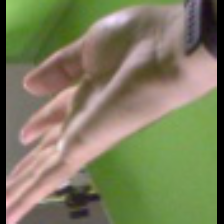

In [112]:
# unnormalize
V_pred_unnormalize_778x2 = V_pred_778x2.numpy().copy()

shift_z = np.min(V_pred_unnormalize_778x2[:, 2])
scale_z = np.max(V_pred_unnormalize_778x2[:, 2])-np.min(V_pred_unnormalize_778x2[:, 2])

V_pred_unnormalize_778x2 = (V_pred_unnormalize_778x2 + 1) * (out_img_size/2)

fig = plot_2d_pts_on_img(I_normalize, V_pred_unnormalize_778x2)
fig.show()

In [113]:
V_pred_778x2

<tf.Tensor: shape=(778, 3), dtype=float32, numpy=
array([[ 0.03731034, -0.04123042,  0.05432098],
       [ 0.03917654,  0.06931337,  0.0429536 ],
       [ 0.03849161, -0.01130166,  0.01171718],
       ...,
       [ 0.02738442,  0.28896314,  0.07451645],
       [ 0.00221951,  0.25783902,  0.02154005],
       [-0.0381618 ,  0.25078896,  0.04734139]], dtype=float32)>

In [114]:
with open('./test1.json', 'w') as t:
    json.dump({'pred':V_pred_778x2.numpy().tolist()}, t)

In [116]:
y_true = [[1., 1], [0., 0.]]
y_pred = [[1., 1.], [1., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
mae(y_true, y_pred).numpy()


0.25

In [27]:
model_ld = create_model()

NameError: name 'create_model' is not defined

In [43]:
image = imageio.imread('../../../storage/sample_friehand/00000'+"000"[:(3-len(str(0)))]+str(0)+'.jpg')

In [ ]:
def process_data_wrapper(projection_func):
    #Load these in process_ds for parallelisation
    def f(image_path, annotation_xyz, *args):
        image = np.array(Image.open(image_path.numpy()))
        annotation_xyz = annotation_xyz.numpy()
        image, annotation, proj_mat = projection_func(image, annotation_xyz, *args)
        image, normalized_image, normalized_annotations, affine_mat = process_data(image, annotation)
    
        return image, normalized_image, normalized_annotations, affine_mat, proj_mat
    return f

def youtube_projection(image, annotation, image_width, image_height, hand_is_left):
    image_height = image_height.numpy()
    image_width = image_width.numpy()
    hand_is_left = hand_is_left.numpy()
    ## Resize
    image = Image.resize((image_width, image_height), 2)
    ## Flip
    flipped_image, flipped_vertices, flip_mat = flip_hand(image, annotation)
    ## Return proj mat
    return flipped_image, flipped_vertices, flip_mat

def freihand_projection(image, annotation_xyz, projection_mat):
    ## Apply projection mat
    # print(annotation_xyz[:3, :])
    annotation_uv = projectPoints(annotation_xyz, projection_mat)
    projection_mat = np.hstack([projection_mat, np.zeros((3, 1))])
    projection_mat = np.vstack([projection_mat, [0, 0, 0, 1]])
    ## Scale z coord
    s_x = np.std(annotation_uv[:, 0]) / np.std(annotation_xyz[:, 0])
    z_cam = s_x * (annotation_xyz[:, 2]).reshape(-1, 1)
    projection_mat[2, 2] = s_x
    ## Add z scale to proj
    annotation_uvd = np.concatenate((annotation_uv[:, :2], z_cam), axis=1)
    ## Return modified proj mat
    # print(annotation_uvd[:3, :])
    return image, annotation_uvd, projection_mat

def unproject_youtube(annotation, affine_mat, proj_mat):
    mat_project = affine_mat @ proj_mat
    mat_unproject = np.linalg.inv(mat_project[:3, :3])
    inv_t = mat_unproject @ mat_project[:3, 3]
    annotation = annotation @ mat_unproject.T + inv_t.T
    return annotation

def unproject_freihand(_annotation, _affine_mat, _proj_mat):
    def f(annotation, affine_mat, proj_mat):
        mat_project = affine_mat
        mat_unproject = np.linalg.inv(mat_project[:3, :3])
        inv_t = mat_unproject @ -mat_project[:3, 3]
        annotation = annotation @ mat_unproject.T + inv_t.T
        annotation[..., 2] = annotation[..., 2] / proj_mat[2, 2]
        annotation[..., 0] = (annotation[..., 0] - proj_mat[0, 2]) / proj_mat[0, 0] * annotation[..., 2]
        annotation[..., 1] = (annotation[..., 1] - proj_mat[1, 2]) / proj_mat[1, 1] * annotation[..., 2]
        return annotation
    _annotation = _annotation.numpy()
    for idx, _ in enumerate(_annotation):
        _annotation[idx] = f(_annotation[idx], _affine_mat[idx].numpy(), _proj_mat[idx].numpy())
    # print(_annotation.shape)
    return _annotation

def process_data(I, V_gt):
    min_coords, max_coords = np.amin(V_gt, axis=0), np.amax(V_gt, axis=0)
    min_uv, max_uv = min_coords[:2].astype(np.int), max_coords[:2].astype(np.int)
    I_crop = I.copy()[min_uv[1]: max_uv[1], min_uv[0]: max_uv[0]]  # u: cols, v: rows

    mat_crop = np.identity(4, dtype=np.float32)
    mat_crop[0, 3] = -min_uv[0]
    mat_crop[1, 3] = -min_uv[1]
    V_crop = V_gt @ mat_crop[:3, :3].T + mat_crop[:3, 3]
    cropped_height, cropped_width, _ = I_crop.shape
    resize_scale = min(out_img_size/cropped_width, out_img_size/cropped_height)
    resized_width, resized_height = (int(cropped_width*resize_scale), int(cropped_height*resize_scale))
    I_resize = cv.resize(I_crop, (resized_width, resized_height), interpolation=cv.INTER_LINEAR)

    mat_resize = np.identity(4, dtype=np.float32)
    mat_resize[0, 0] = resize_scale
    mat_resize[1, 1] = resize_scale
    V_resize = V_crop @ mat_resize[:3, :3].T + mat_resize[:3, 3]
    
    I_pad = np.zeros([out_img_size, out_img_size, 3], dtype=np.float32)
    u_pad_start, v_pad_start = int((out_img_size - resized_width) / 2), int((out_img_size - resized_height) / 2)
    u_pad_end, v_pad_end = u_pad_start + resized_width, v_pad_start + resized_height
    I_pad[v_pad_start : v_pad_end, u_pad_start : u_pad_end] = I_resize

    mat_pad = np.eye(4, dtype=np.float32)
    mat_pad[0, 3] = u_pad_start
    mat_pad[1, 3] = v_pad_start
    V_pad = V_resize @ mat_pad[:3, :3].T + mat_pad[:3, 3]

    I_normalize = I_pad.copy()
    I_normalize /= 255

    shift_z = np.min(V_pad[:, 2])
    scale_z = np.max(V_pad[:, 2])-np.min(V_pad[:, 2])
    
    mat_normalize = np.eye(4, dtype=np.float32)
    mat_normalize[0, 0] = 2/out_img_size
    mat_normalize[1, 1] = 2/out_img_size
    mat_normalize[2, 2] = 2/scale_z

    mat_normalize[0:3, 3] = [-1, -1, -(shift_z*2)/scale_z-1]
    
    V_normalize = np.ones((778, 4))
    V_normalize[:, :3] = V_pad.copy()
    V_normalize = (mat_normalize @ V_normalize.T).T[:, :3]
#     print(np.sum(I_normalize), np.sum(V_normalize))
#     random_angle_in_degrees = np.random.rand() * (ROTATION_RANGE[1]-ROTATION_RANGE[0]) - ROTATION_RANGE[0]
#     random_scale = np.random.rand()*0.1 + 1.0
#     cv_mat_rot_scale = cv2.getRotationMatrix2D((out_img_size/2, out_img_size/2), random_angle_in_degrees, random_scale)
#     rotated_and_scaled_image = cv2.warpAffine(I_normalize, cv_mat_rot_scale, (out_img_size, out_img_size), borderValue=0, flags=cv2.INTER_NEAREST)
#     rotated_and_scaled_image *= random_scale

#     # print(cv_mat_rot_scale)
#     mat_rot_scale = np.eye(4, dtype=np.float64)
#     mat_rot_scale[:2, :2] = cv_mat_rot_scale[:2, :2]
#     tmp = np.zeros((778, 4))
#     tmp[:,:3] = V_normalize
#     tmp[:, 3] = 1
#     rotated_scaled_vertices = tmp @ mat_rot_scale.T
    mat_process = mat_normalize @ mat_pad @ mat_resize @ mat_crop
    # print(mat_process)
#     print(rotated_and_scaled_image, rotated_scaled_vertices)
    return I, I_normalize, V_normalize[:, :3], mat_process

def get_raw_data_as_tf_dataset(storage_dir, images, annotations, dataset):
#     image_dct = {}
#     image_path = []
#     image_width = []
#     image_height = []
#     hand_is_left = []
#     annotation_idx = []
#     map_img_to_path(image_dct, images)
#     map_img_to_ann(image_dct, annotations)
#     for idx, img in enumerate(image_dct.keys()):
#         image_dct[img]['path'] = os.path.join(storage_dir, image_dct[img]['path'])
#         for ann in image_dct[img]['ann']:
#             image_path.append(image_dct[img]['path'])
#             image_width.append(image_dct[img]['width'])
#             image_height.append(image_dct[img]['height'])
#             hand_is_left.append(annotations[ann]['is_left'])
#             annotation_idx.append(ann)

#         if idx >= 1:
#             break
        
    ## Friehand read
    anns = []
    image_path = []
    proj_mat = []
    for idx, ann in enumerate(annotations):
        anns.append(ann['V'])
        proj_mat.append(ann['K'])
        image_path.append('../storage/sample_friehand/'+"00000000"[:(8-len(str(idx)))]+str(idx)+'.jpg')
        # if idx==1:
        #     break
    ds_raw = tf.data.Dataset.from_tensor_slices((image_path, anns, proj_mat))
    return ds_raw

def process_ds(projection_func):
    #Load image and annotations from text file later
    def f(image_path, annotation, *args):
        image, normalized_image, normalized_annotations, affine_mat, proj_mat = tf.py_function(
            func = process_data_wrapper(projection_func),
            inp = [image_path, annotation, *args],
            Tout = [tf.uint8, tf.float32, tf.float32, tf.float32, tf.float32]
        )
        
        annotation.set_shape([778, 3])
        normalized_image.set_shape([out_img_size, out_img_size, 3])
        normalized_annotations.set_shape([778, 3])
        affine_mat.set_shape([4, 4])
        proj_mat.set_shape([4, 4])

        return (
            {"I_raw": image, "I" : normalized_image, "proj_mat" : proj_mat, "affine_mat" : affine_mat},
            {"V" : normalized_annotations, "annotations_xyz" : annotation}
        )
    return f
#     return normalized_image, normalized_annotations

def process_tf_dataset(ds_raw, dataset):
    if dataset=="youtube":
        ds_processed = ds_raw.map(
                            lambda image_path, image_width, image_height, hand_is_left, annotation_id : process_ds(youtube_projection)(
                                    image_path, annotation_id, image_width, image_height, hand_is_left))
    else:
        ds_processed = ds_raw.map(lambda image_path, annotation_id, proj_mat : process_ds(freihand_projection)(image_path, annotation_id, proj_mat))
        ds_processed = ds_processed.apply(tf.data.experimental.ignore_errors())
        ## Apply ignore errors
    return ds_processed

def get_processed_dataset_as_tf_dataset(storage_dir, images, annotations, dataset="freihand"):
    ds_raw = get_raw_data_as_tf_dataset(storage_dir, images, annotations, dataset)
    
    n_data = ds_raw.cardinality().numpy()
    train_frac = 1
    n_data_train = int(n_data * train_frac)
    ds_train = ds_raw.take(n_data_train)
    ds_val = ds_raw.skip(n_data_train)
    ds_train = process_tf_dataset(ds_train, dataset)
#     ds_train = ds_train.apply(tf.data.experimental.ignore_errors())
    ds_val = process_tf_dataset(ds_val, dataset)

    return ds_train, ds_val




In [ ]:
for ds in ds_train:
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
#     tf.debugging.check_numerics(ds[0]['I'][0], "asd")
    ax1.imshow(ds[0]['I'][0])
    # tf.print(ds[0]['I'][0])

    ax2 = fig.add_subplot(132)
#     tf.debugging.check_numerics(ds[1]['V'][0], "asd")
    ax2.scatter(ds[1]['V'][0][:, 0], ds[1]['V'][0][:, 1])
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    
    unproject_v = unproject_freihand(ds[1]['V'][0:1], ds[0]['affine_mat'][0:1], ds[0]['proj_mat'][0:1])[0]

    mat_project = ds[0]['proj_mat'][0]
    fx = mat_project[0, 0]
    fy = mat_project[1, 1]
    cx = mat_project[0, 2]
    cy = mat_project[1, 2]
    V_u = fx * unproject_v[:, 0] / unproject_v[:, 2] + cx
    V_v = fy * unproject_v[:, 1] / unproject_v[:, 2] + cy
    
    ax3 = fig.add_subplot(133)
#     tf.debugging.check_numerics(ds[1]['V'][0], "asd")
#     vertex_set = ds[1]['V'][0].numpy()
    ax3.scatter(V_u, V_v, s=1)
    ax3.imshow(ds[0]['I_raw'][0])
    break
    
#     break
    
# for ds in ds_train1:
#     fig = plt.figure()
#     ax1 = fig.add_subplot(121)
#     ax1.imshow(ds[0]['I'][0].numpy())
# #     tf.print(ds[0]['I'][0])

#     ax2 = fig.add_subplot(122)
#     vertex_set = ds[1]['V'][0].numpy()
#     ax2.scatter(vertex_set[:, 0], vertex_set[:, 1])
#     ax2.set_xlim(-1, 1)
#     ax2.set_ylim(1, -1)
#     ax2.set_aspect("equal")
#     print(np.min(ds[1]['V'][0].numpy()), np.max(ds[1]['V'][0].numpy()))